# **TP3 - Grupo 4**
Pedro Paulo Costa Pereira - A88062

Tiago André Oliveira Leite - A91693

# **Problema - Sistema de Travgem ABS**
No contexto do sistema de travagem ABS (“Anti-Lock Breaking System”), pretende-se construir um autómato híbrido que descreva o sistema e que  possa ser usado para verificar as suas propriedades dinâmicas.

    
1. A componente discreta do autómato contém os modos:  `Start`,  `Free`,  `Stopping`, `Blocked`, e `Stopped`. No modo `Free`  não existe qualquer força de travagem; no modo `Stopping` aplica-se a força de travagem alta; no modo `Blocked` as rodas estão bloqueadas em relação ao corpo mas o veículo  desloca-se; no modo `Stopped` o veículo está imobilizado.


2. A componente contínua  do autómato usa variáveis contínuas $\,V,v\,$$ para descrever a  `velocidade do corpo`  do veículo em relação ao solo e a `velocidade linear das rodas` também em relação ao solo. 
    Assume-se que o sistema de travagem exerce uma força de atrito  nos travões proporcional à diferença das duas velocidades.  A dinâmica contínua está descrita  abaixo no bloco Equaçoes de Fluxo.


3. Os “switchs” (“jumps”) são a componente de projeto deste trabalho; cabe ao aluno definir quais devem ser estas  condições de modo a que o sistema tenha um comportamento desejável: imobilize-se depressa e não “derrape” muito.


4. Faça
    1. Defina um autómato híbrido que descreva a dinâmica do sistema segundo as notas abaixo indicadas e com os “switchs” por si escolhidos.
    2. Modele em lógica temporal linear LT  propriedades que caracterizam o comportamento desejável do sistema. Nomeadamente 
        1. ”o veículo imobiliza-se completamente em menos de $t$ segundos” 
        2. “a velocidade $V$ diminui sempre com o tempo”.
    3. Codifique em SMT’s o modelo que definiu em a.
    4. Codifique a verificação das propriedades temporais que definiu em b.

<img src="esquema.png" style="width:700px;height:400px"/>

**Equações de Fluxo** 

1. Durante  a travagem não existe qualquer  força no sistema excepto as forças de atrito. Quando uma superfície se desloca em relação à outra, a força de atrito  é proporcional à força de compressão entre elas. 
2. No contacto rodas/solo o atrito é constante porque a força de compressão é o peso; tem-se $f = a\cdot P$ sendo  $a$ a constante de atrito e $P$ o peso. Ambos são fixos e independentes do modo.
3. No contacto corpo/rodas,  a força de compressão é a força de travagem que aqui se assume como proporcional à diferença de velocidades  $F =  c\cdot (V-v)$.  A  constante de proporcionalidade $c$ depende do modo: é elevada no modo `Stopping` e baixa nos outros.
4. Existe um atrito no contacto corpo/ar  que é aproximado por uma constante positiva $\,b$.
5. As equações que traduzem a dinâmica  do sistema são, em todos os modo excepto `Blocked`,

$$\begin{array}{c} \dot{V} & = & - c\cdot(V-v) - b\\ \dot{v} & = & -a\cdot P  + c\cdot(V-v) \end{array}$$   

e , no modo `Blocked`,  a dinâmica do sistema é  regida por

$$
\begin{array}{c} (V = v) \;\land\; (\,\dot{V}\,=\, -a\cdot P - b\,) \end{array} $$


6. Tanto no modo `Blocked`  como no modo `Free`  existe um “timer” que impede que se permaneça nesses modo mais do que $\,\tau\,$segundos. Os $\mathsf{jumps}(V,v,t,V',v',t')\,$ com origem nesses modos devem forçar esta condição.
7. No instante inicial assume-se $\,V = v\,=\,V_0$  ,  em que a velocidade $V_0$ é o “input” do problema.

In [26]:
from z3 import *
import pygraphviz as pgv
from IPython.display import Image

In [28]:
def draw(dot):
    return Image(pgv.AGraph(dot).draw(format='png', prog='dot'))

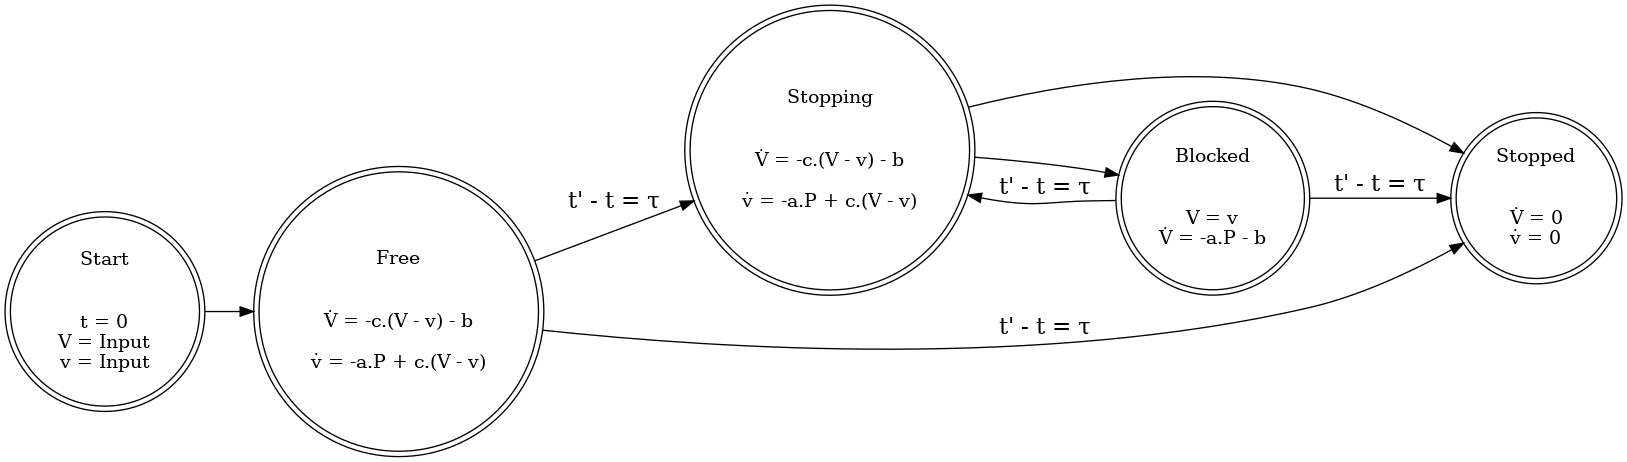

In [237]:
t= 1;
ABS = """digraph{
    rankdir=LR;
    Start [shape=doublecircle, label="Start\n\n\nt = 0\nV = Input\nv = Input"];
    Free [shape = doublecircle, label="Free\n\n\nV̇ = -c.(V - v) - b\n\nv̇ = -a.P + c.(V - v)"];
    Stopping [shape = doublecircle, label="Stopping\n\n\nV̇ = -c.(V - v) - b\n\nv̇ = -a.P + c.(V - v)"];
    Blocked [shape = doublecircle, label="Blocked\n\n\nV = v\nV̇ = -a.P - b"];
    Stopped [shape = doublecircle, label="Stopped\n\n\nV̇ = 0\nv̇ = 0"];
  
    Start -> Free;
    Free -> Stopping [label="t' - t = τ",fontsize="17"];
    Free -> Stopped [label="t' - t = τ",fontsize="17"];
    Stopping -> Blocked;
    Stopping -> Stopped;
    Blocked -> Stopped [label="t' - t = τ",fontsize="17"];
    Blocked -> Stopping [label="t' - t = τ",fontsize="17"];

    
}"""

draw(ABS)

In [87]:
Mode, (START,FREE, STOPPING, BLOCKED, STOPPED) = EnumSort('Mode', ('START','FREE','STOPPING', 'BLOCKED','STOPPED'))

In [13]:
def declare(i):
    s = {}
    s['t'] = Real('t'+str(i)) # tempo
    s['v'] = Real('v'+str(i)) # velociadae veiculo
    s['r'] = Real('r'+str(i)) # velocidade rodas
    s['m'] = Const('m'+str(i),Mode) # modo
    return s

In [12]:
def init(s, v_inicial):
    return And(s['t'] == 0, s['v'] == v_inicial, s['r'] == v_inicial, s['m'] == START) 

In [18]:
def trans(s,p):
    
    start2free = And()
    start2stopping = And()
    start2blocked = And()
    
    free2stopping  =  And()
    free2stopped = And()
    free2free = And()
    
    stopping2free = And()
    stopping2blocked = And()
    stopping2stopped = And()
    stopping2stopping = And()
    
    blocked2stopped = And()
    blocked2free = And()
    blocked2stopping = And()
    
    stopped2stopped = And()
    stopped2free = And()
    
    
    
    return Or(start2free, start2stopping, start2blocked,
              free2stopping, free2stopped, free2free,
              stopping2free, stopping2blocked, stopping2stopped, stopping2stopping,
              blocked2stopped, blocked2free, blocked2stopping,
              stopped2stopped, stopped2free)

In [ ]:
def gera_traco(declare,init,trans,v_inicial, k):
    s = Solver()
    traco = {}
    for i in range(k):
        traco[i] = decalre(i)
    s.add(init(traco[0],v_inicial))
    for i in range(k-1):
        s.add(trans(traco[i],traco[i+1]))
    status = s.check()
    if status == sat:
        m = s.model()
        for i in range(k):
            print(i)
            for v in traco[i]:
                if traco[i][v].sort == RealSort():
                    print(v,'=', float(m[traco[i][v]].numerator_as_long())/float(m[traco[i][v]].denominator_as_long()))
                else:
                    print(v,"=",m[traco[i][v]])
    elif status == unsat:
        print("Não ha execuções possiveis")
    else:
        print("Resultado impossivel de obter!")

In [21]:
def bmc_always(declare,init,trans,v_inicial,inv,k):
    for i in range(1, k+1):
        s = Solver()
        traco = {}
        for i in range(k):
            traco[i] = declare(i)
        s.add(init(traco[0], v_inical))
        for i in range(k-1):
            s.add(trans(traco[i],traco[i+1]))
        s.add(Not(inv(traco[k-1])))
        status = s.check()
        if status == sat:
            m = s.model()
            for i in range(k):
                print(i)
                for v in traco[i]:
                    if traco[i][v].sort() == RealSort():
                        print(v,'=', float(m[traco[i][v]].numerator_as_long())/float(m[traco[i][v]].denominator_as_long()))
                    else:
                        print(v,"=",m[traco[i][v]])
            return
    print("A propriedade pode ser verdade...")